In [ ]:
import sys
sys.path.append('z2vqe/src')
import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from z2_lgt import create_hamiltonian, initial_state_vector, get_symmetry_sector, subspace_diagonalization

In [ ]:
num_sites = 8
j_hopping = 1.
f_gauge = 0.5
mass = 2.

vqe_instances = {}

with h5py.File(f'vqe_2000iter.h5') as source:
    for group in source.values():
        if (group['num_sites'][()] == num_sites
                and np.isclose(group['j_hopping'][()], j_hopping)
                and np.isclose(group['f_gauge'][()], f_gauge)
                and np.isclose(group['mass'][()], mass)):
            num_layers = group['num_layers'][()]
            if (instances := vqe_instances.get(num_layers)) is None:
                vqe_instances[num_layers] = group['energies'][()]
            else:
                vqe_instances[num_layers] = np.concatenate([instances, group['energies'][()]], axis=1)

In [33]:
hamiltonian = create_hamiltonian(num_sites, j_hopping, f_gauge, mass, 0, 'closed', False)
init_state = initial_state_vector(num_sites)
gauss_sector, u1_sector = get_symmetry_sector(init_state)
eigvals, eigvecs = subspace_diagonalization(hamiltonian, gauss_sector, u1_sector)

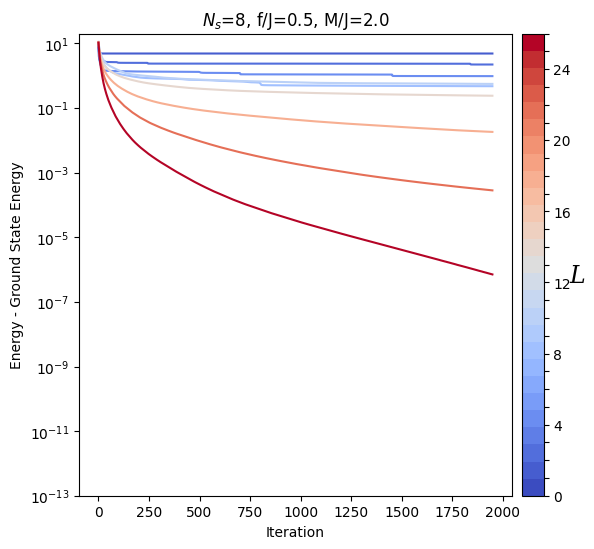

In [34]:
max_num_layers = max(vqe_instances.keys())
colormap = plt.colormaps["coolwarm"].resampled(max_num_layers + 1)

fig, ax = plt.subplots(figsize=(6, 6))

for num_layers, instances in vqe_instances.items():
    ax.semilogy(np.arange(1950), np.mean(instances[:1950], axis=1) - eigvals[0],
                color=colormap(num_layers))
    # ax.semilogy(np.arange(instances.shape[0]), np.mean(instances, axis=1) - eigvals[0],
    #             color=colormap(num_layers))

ax.set_xlabel('Iteration')
ax.set_ylabel('Energy - Ground State Energy')
ax.set_title(f'$N_s$={num_sites}, f/J={f_gauge / j_hopping}, M/J={mass / j_hopping}')
ax.set_ylim([1e-13, 20])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap), cax=cax)
cbar.set_label('L', fontsize=17, fontname='DejaVu Serif', rotation=0, fontstyle='italic')
labels = [f'{i}' if i % 4 == 0 else '' for i in range(max_num_layers + 1)]
cbar.set_ticks(np.linspace(0., 1., max_num_layers + 1))
cbar.set_ticklabels(labels)